In [4]:
import sqlite3
import pandas as pd
import pandas_ta as ta
import numpy as np
import math
import scipy.stats as stats
from scipy.stats import norm
from datetime import datetime
from datetime import timedelta

import mplfinance as mpf
import matplotlib.pyplot as plt
import vectorbt as vbt

In [5]:
# Ignore Pandas Warning
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Data Preperation

In [6]:
# Read CSV
df_SET = pd.read_csv('stock_price_2017_to_Q2-2022.csv')

# Convert string to datetime
df_SET['Date'] = pd.to_datetime(df_SET['Date'], format = '%d/%m/%Y')

# drop row close price = 0 
df_SET.drop(df_SET.loc[df_SET['Close'] == 0].index,inplace = True)

df_SET.columns

Index(['Date', 'Market', 'Symbol', 'Prior', 'Open', 'High', 'Low', 'Close',
       'Change', '%Change', 'Average', 'AOM Volume', 'AOM Value', 'TR Volume',
       'TR Value', 'Total Volume', 'Total Value', 'Market Cap', 'PE', 'PEG',
       'PBV', 'BVPS', 'Dividend Yield', '12M Dividend Yield',
       'Volume Turnover', 'Par', 'Listed Share'],
      dtype='object')

In [7]:
# Get all Date and Symbol (All Combination)

# Get all business date
df_all_business_date = pd.DataFrame()
df_all_business_date['Date'] = pd.bdate_range(start='2017-01-04', end='2022-06-30')

# Get all symbol
df_all_symbol = pd.DataFrame()
df_all_symbol = pd.DataFrame(df_SET.groupby('Symbol').groups.keys())
df_all_symbol.rename(columns={0:'Symbol'}, inplace=True)

# Get all combination
df_all_bdate_symbol = pd.merge(df_all_business_date, df_all_symbol, how='cross')
df_all_bdate_symbol['MATCHING-Date-Symbol'] = df_all_bdate_symbol['Date'].astype(str) + '-' + df_all_bdate_symbol['Symbol']

df_all_bdate_symbol

,Date,Symbol,MATCHING-Date-Symbol
0,2017-01-04,2S,2017-01-04-2S
1,2017-01-04,3K-BAT,2017-01-04-3K-BAT
2,2017-01-04,7UP,2017-01-04-7UP
3,2017-01-04,A,2017-01-04-A
4,2017-01-04,AAV,2017-01-04-AAV
...,...,...,...
1025307,2022-06-30,WR,2022-06-30-WR
1025308,2022-06-30,XPG,2022-06-30-XPG
1025309,2022-06-30,YCI,2022-06-30-YCI
1025310,2022-06-30,YNP,2022-06-30-YNP


In [8]:
# Copy to new DataFrame
df_data = df_SET[['Date','Symbol', 'Close', '%Change', 'Market Cap', 'PE', '12M Dividend Yield']]

# Matching Date-Symbol 
df_data['MATCHING-Date-Symbol'] = df_data['Date'].astype(str) + '-' + df_data['Symbol']

# Map all date-symbol
df_data = pd.merge(df_all_bdate_symbol, df_data[['MATCHING-Date-Symbol', 'Close', '%Change', 'Market Cap', 'PE', '12M Dividend Yield']], how='left', on='MATCHING-Date-Symbol')

# Matching YEAR-Symbol
df_data['YEAR'] = pd.DatetimeIndex(df_data['Date']).year      
df_data['MATCHING-YEAR-Symbol'] = df_data['YEAR'].astype(str) + '-' + df_data['Symbol']

# Re-arranging
df_data = df_data[['Date','YEAR','Symbol','MATCHING-YEAR-Symbol','MATCHING-Date-Symbol','Close','%Change','Market Cap','PE','12M Dividend Yield']]

### ------------------------------------------------------------------------------------------------------------------------------------------------ ###
df_data

,Date,YEAR,Symbol,MATCHING-YEAR-Symbol,MATCHING-Date-Symbol,Close,%Change,Market Cap,PE,12M Dividend Yield
0,2017-01-04,2017,2S,2017-2S,2017-01-04-2S,NaN,NaN,NaN,NaN,NaN
1,2017-01-04,2017,3K-BAT,2017-3K-BAT,2017-01-04-3K-BAT,NaN,NaN,NaN,NaN,NaN
2,2017-01-04,2017,7UP,2017-7UP,2017-01-04-7UP,0.88000,0.000000,1.670240e+09,NaN,NaN
3,2017-01-04,2017,A,2017-A,2017-01-04-A,6.30000,0.000000,6.174000e+09,23.29,NaN
4,2017-01-04,2017,AAV,2017-AAV,2017-01-04-AAV,5.80049,0.826446,2.958500e+10,14.07,NaN
...,...,...,...,...,...,...,...,...,...,...
1025307,2022-06-30,2022,WR,2022-WR,2022-06-30-WR,NaN,NaN,NaN,NaN,NaN
1025308,2022-06-30,2022,XPG,2022-XPG,2022-06-30-XPG,1.72000,-1.714286,1.609122e+10,NaN,NaN
1025309,2022-06-30,2022,YCI,2022-YCI,2022-06-30-YCI,NaN,NaN,NaN,NaN,NaN
1025310,2022-06-30,2022,YNP,2022-YNP,2022-06-30-YNP,NaN,NaN,NaN,NaN,NaN


In [9]:
### ------------------------------------------------------------------------------------------------------------------------------------------------ ###
### ------- SIZE ------- ###

# Calculate SIZE
df_data['LN MARKET CAP'] = np.log(df_data['Market Cap'])

### ------------------------------------------------------------------------------------------------------------------------------------------------ ###
### ---- MOMENTUM ---- ###

rolling_period = 365   # Rollback Days
df_rollback_1Y = pd.DataFrame()

df_rollback_1Y = df_data[['Date','Symbol','Close']]
df_rollback_1Y['Date-Rollback-1Y'] = df_rollback_1Y['Date'] + pd.Timedelta(rolling_period,'d')      # Add rollback 1 year date
df_rollback_1Y['DateOfWeek-Rollback_1Y'] = df_rollback_1Y['Date-Rollback-1Y'].dt.dayofweek          # Add day of week

# Saturday
df_rollback_1Y['DateOfWeek-holiday'] = df_rollback_1Y['DateOfWeek-Rollback_1Y'] - 4                 # Saturday = 1
df_Saturday = pd.DataFrame()
df_Saturday = df_rollback_1Y[df_rollback_1Y['DateOfWeek-holiday'] == 1]                             # df all Saturday
df_Saturday['Date-Rollback-1Y-no-weekend'] = df_Saturday['Date-Rollback-1Y'] + pd.Timedelta(-1,'d') # roll back 1Day to FRIDAY

df_Saturday = df_Saturday[['Date','Date-Rollback-1Y-no-weekend']].drop_duplicates()

# Sunday
df_rollback_1Y['DateOfWeek-holiday'] = df_rollback_1Y['DateOfWeek-Rollback_1Y'] - 4                 # sunday = 2
df_Sunday = pd.DataFrame()
df_Sunday = df_rollback_1Y[df_rollback_1Y['DateOfWeek-holiday'] == 2]                               # df all sunday
df_Sunday['Date-Rollback-1Y-no-weekend'] = df_Sunday['Date-Rollback-1Y'] + pd.Timedelta(-2,'d')     # roll back 2Day to FRIDAY

df_Sunday = df_Sunday[['Date','Date-Rollback-1Y-no-weekend']].drop_duplicates()

# Holiday
df_Holiday = pd.DataFrame()
df_Holiday = pd.concat([df_Saturday,df_Sunday])
df_Holiday.rename(columns={'Date-Rollback-1Y-no-weekend':"Date-Rollback-1Y NEW"}, inplace = True)

# Mapping to all Date
df_rollback_1Y  = df_rollback_1Y[df_rollback_1Y ['Close'].notna()]
df_rollback_1Y = pd.merge(df_rollback_1Y,df_Holiday[['Date','Date-Rollback-1Y NEW']], how='left',on='Date')

df_rollback_1Y['Date-Rollback-1Y NEW'].fillna(df_rollback_1Y['Date-Rollback-1Y'])
            # check = df_rollback_1Y.drop_duplicates(subset=['Date-Rollback-1Y NEW'])

df_rollback_1Y = df_rollback_1Y[['Date-Rollback-1Y NEW','Symbol','Close']]

df_rollback_1Y.rename(columns={'Date-Rollback-1Y NEW':"Date"}, inplace = True)
df_rollback_1Y.rename(columns={'Close':"Close-Rollback-1Y"}, inplace = True)

# MATCHING
df_rollback_1Y['MATCHING-Date-Symbol'] = df_rollback_1Y['Date'].astype(str) + '-' + df_rollback_1Y['Symbol']

# Calculate Momentum
df_monmentum = pd.merge(df_data[['Date','Symbol','MATCHING-Date-Symbol','MATCHING-YEAR-Symbol','Close']],df_rollback_1Y[['MATCHING-Date-Symbol','Close-Rollback-1Y']], how='left',on='MATCHING-Date-Symbol')
df_monmentum['MOMENTUM'] = 100 * (df_monmentum['Close'] - df_monmentum['Close-Rollback-1Y']) / df_monmentum['Close-Rollback-1Y']

df_monmentum

# Add MOMENTUM to DataFrame
df_data = pd.merge(df_data, df_monmentum[['MATCHING-Date-Symbol','Close-Rollback-1Y','MOMENTUM']], how='left', on='MATCHING-Date-Symbol')

In [10]:
### ------------------------------------------------------------------------------------------------------------------------------------------------ ###
### --- VOLATILITY --- ###

df_volatility = df_data[['Symbol','MATCHING-Date-Symbol','Close','%Change']]

df_volatility['NULL'] = df_volatility['Close'].isnull()
df_volatility['VOLATILITY'] = df_volatility[df_volatility['NULL'] == False].groupby('Symbol')['%Change'].rolling(365).std().reset_index(0,drop=True)

# Add MOMENTUM to DataFrame
df_data = pd.merge(df_data, df_volatility[['MATCHING-Date-Symbol','VOLATILITY']], how='left', on='MATCHING-Date-Symbol')

### ------------------------------------------------------------------------------------------------------------------------------------------------ ###
### --- Clear DataFrame --- ###

df_Saturday = 0
df_Sunday = 0
df_Holiday = 0
df_rollback_1Y = 0
df_monmentum = 0
f_volatility = 0

### ------------------------------------------------------------------------------------------------------------------------------------------------ ###
### --- Re-arranging DataFrame  --- ###

df_stock = df_data[['Date','YEAR','Symbol','MATCHING-YEAR-Symbol','MATCHING-Date-Symbol','Close','LN MARKET CAP','PE','12M Dividend Yield', 'MOMENTUM', 'VOLATILITY']]
df_stock.rename(columns={'LN MARKET CAP':'SIZE','PE':'VALUE','12M Dividend Yield':'YIELD'}, inplace=True)

df_stock


,Date,YEAR,Symbol,MATCHING-YEAR-Symbol,MATCHING-Date-Symbol,Close,SIZE,VALUE,YIELD,MOMENTUM,VOLATILITY
0,2017-01-04,2017,2S,2017-2S,2017-01-04-2S,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-04,2017,3K-BAT,2017-3K-BAT,2017-01-04-3K-BAT,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-04,2017,7UP,2017-7UP,2017-01-04-7UP,0.88000,21.236233,NaN,NaN,NaN,NaN
3,2017-01-04,2017,A,2017-A,2017-01-04-A,6.30000,22.543613,23.29,NaN,NaN,NaN
4,2017-01-04,2017,AAV,2017-AAV,2017-01-04-AAV,5.80049,24.110533,14.07,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1025307,2022-06-30,2022,WR,2022-WR,2022-06-30-WR,NaN,NaN,NaN,NaN,NaN,NaN
1025308,2022-06-30,2022,XPG,2022-XPG,2022-06-30-XPG,1.72000,23.501540,NaN,NaN,NaN,5.550541
1025309,2022-06-30,2022,YCI,2022-YCI,2022-06-30-YCI,NaN,NaN,NaN,NaN,NaN,NaN
1025310,2022-06-30,2022,YNP,2022-YNP,2022-06-30-YNP,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df_stock

,Date,YEAR,Symbol,MATCHING-YEAR-Symbol,MATCHING-Date-Symbol,Close,SIZE,VALUE,YIELD,MOMENTUM,VOLATILITY
0,2017-01-04,2017,2S,2017-2S,2017-01-04-2S,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-04,2017,3K-BAT,2017-3K-BAT,2017-01-04-3K-BAT,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-04,2017,7UP,2017-7UP,2017-01-04-7UP,0.88000,21.236233,NaN,NaN,NaN,NaN
3,2017-01-04,2017,A,2017-A,2017-01-04-A,6.30000,22.543613,23.29,NaN,NaN,NaN
4,2017-01-04,2017,AAV,2017-AAV,2017-01-04-AAV,5.80049,24.110533,14.07,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1025307,2022-06-30,2022,WR,2022-WR,2022-06-30-WR,NaN,NaN,NaN,NaN,NaN,NaN
1025308,2022-06-30,2022,XPG,2022-XPG,2022-06-30-XPG,1.72000,23.501540,NaN,NaN,NaN,5.550541
1025309,2022-06-30,2022,YCI,2022-YCI,2022-06-30-YCI,NaN,NaN,NaN,NaN,NaN,NaN
1025310,2022-06-30,2022,YNP,2022-YNP,2022-06-30-YNP,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Check YIELD
df_stock[df_stock['YIELD'].notna()]

,Date,YEAR,Symbol,MATCHING-YEAR-Symbol,MATCHING-Date-Symbol,Close,SIZE,VALUE,YIELD,MOMENTUM,VOLATILITY
370175,2018-12-28,2018,A,2018-A,2018-12-28-A,6.65000,22.597680,69.18,0.60,0.757576,0.371947
370176,2018-12-28,2018,AAV,2018-AAV,2018-12-28-AAV,3.99378,23.737329,24.98,7.98,-31.707317,1.563090
370177,2018-12-28,2018,ABPIF,2018-ABPIF,2018-12-28-ABPIF,6.15000,22.028892,NaN,13.38,-28.070175,1.117866
370181,2018-12-28,2018,ADVANC,2018-ADVANC,2018-12-28-ADVANC,172.50000,26.963542,16.79,4.26,-9.685864,1.162597
370182,2018-12-28,2018,AEONTS,2018-AEONTS,2018-12-28-AEONTS,182.00000,24.540978,13.12,2.53,75.845411,2.675526
...,...,...,...,...,...,...,...,...,...,...,...
1025301,2022-06-30,2022,WICE,2022-WICE,2022-06-30-WICE,12.00000,22.780308,12.79,1.92,NaN,3.291596
1025302,2022-06-30,2022,WIIK,2022-WIIK,2022-06-30-WIIK,1.95000,21.213980,19.82,4.62,NaN,2.197374
1025304,2022-06-30,2022,WORK,2022-WORK,2022-06-30-WORK,22.80000,23.032586,42.18,2.54,NaN,3.075840
1025305,2022-06-30,2022,WP,2022-WP,2022-06-30-WP,4.70000,21.614013,28.21,3.19,NaN,2.514175


In [13]:
# Check MOMENTUM
df_stock[df_stock['MOMENTUM'].notna()]

,Date,YEAR,Symbol,MATCHING-YEAR-Symbol,MATCHING-Date-Symbol,Close,SIZE,VALUE,YIELD,MOMENTUM,VOLATILITY
187594,2018-01-05,2018,7UP,2018-7UP,2018-01-05-7UP,0.56000,20.981932,NaN,NaN,-37.777778,NaN
187595,2018-01-05,2018,A,2018-A,2018-01-05-A,6.65000,22.597680,61.18,NaN,5.555556,NaN
187596,2018-01-05,2018,AAV,2018-AAV,2018-01-05-AAV,5.80049,24.110533,28.36,NaN,-5.426357,NaN
187597,2018-01-05,2018,ABPIF,2018-ABPIF,2018-01-05-ABPIF,8.60000,22.364202,NaN,NaN,2.380952,NaN
187598,2018-01-05,2018,ACC,2018-ACC,2018-01-05-ACC,0.52000,20.251661,NaN,NaN,-23.529412,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1022440,2022-06-24,2022,WORK,2022-WORK,2022-06-24-WORK,22.50000,23.019341,41.62,2.58,5.633803,3.129272
1022441,2022-06-24,2022,WP,2022-WP,2022-06-24-WP,4.72000,21.618259,28.34,3.18,-4.838710,2.522455
1022442,2022-06-24,2022,WPH,2022-WPH,2022-06-24-WPH,3.26000,21.394167,6.49,3.07,61.386139,2.819685
1022444,2022-06-24,2022,XPG,2022-XPG,2022-06-24-XPG,1.71000,23.495709,NaN,NaN,-49.956834,5.558122


# Setup Function

In [14]:
# Select FACTOR
# factor = 'SIZE'

def factor_index(factor,z_direction=1):

    # Data Preperation
    df_index = pd.DataFrame()
    df_index = df_stock[['Date','YEAR','Symbol','MATCHING-YEAR-Symbol','MATCHING-Date-Symbol','Close', factor]]
    df_index = df_index[df_index['Close'].notna()]
    df_index = df_index[df_index[factor].notna()]

    # Get YEAR-BOY-EOY (beginning/ending date of year)
    year_range = df_index.groupby('YEAR').groups.keys()
    list_year_BOY_EOY = []

    for year_i in year_range:
        BOY_date = df_index['Date'][df_index['YEAR'] == int(year_i)].min()
        EOY_date = df_index['Date'][df_index['YEAR'] == int(year_i)].max()
        list_year_BOY_EOY.append({'Year':int(year_i),'BOY':BOY_date,'EOY':EOY_date})

    year_range_BOY_EOY = pd.DataFrame()
    year_range_BOY_EOY = pd.DataFrame(list_year_BOY_EOY, columns=['Year','BOY','EOY'])

    ########## Weight Score Calculation ##########
    ##############################################

    df_weight = pd.DataFrame()
    weight = pd.DataFrame()

    for year_index in year_range_BOY_EOY.index.values:

        cal_year = year_range_BOY_EOY['Year'][year_index]
        cal_date = [year_range_BOY_EOY['BOY'][year_index]]
        
                    # if year_index == 0:
                    #     cal_date = [year_range_BOY_EOY['BOY'][year_index]]
                    # else:
                    #     cal_date = [year_range_BOY_EOY['EOY'][year_index - 1]]

        # New df_weight [data in cal_date]
        weight = df_index[['Date','Symbol','Close',factor]][df_index['Date'].isin(cal_date)].dropna()     # stock price in calculation date
        weight['YEAR'] = cal_year
        weight['MATCHING-YEAR-Symbol'] = str(cal_year) + '-' + df_index['Symbol']

        # Z-SCORE
        weight['FACTOR Z-SCORE'] = stats.zscore(weight[factor] * z_direction).dropna()
        weight['FACTOR Z-SCORE CUM.NORM.DIST'] = norm.cdf(weight['FACTOR Z-SCORE'])

        # Weight-SCORE
        weight['WEIGHT'] = weight['FACTOR Z-SCORE CUM.NORM.DIST'] / weight['FACTOR Z-SCORE CUM.NORM.DIST'].sum()

        # Reset DataFrame
        df_weight = pd.concat([df_weight,weight])

    # Insert Weight Score to each year
    df_index = pd.merge(df_index,df_weight[['MATCHING-YEAR-Symbol','WEIGHT']], how='left',on='MATCHING-YEAR-Symbol').replace(np.nan, 0)

    ############# Index Calculation ##############
    ##############################################

    # INDEX INITIAL VALUE
    df_BOY = pd.DataFrame()
    initial_cash_amount = 1000000
    EOY_cash_amount = 0

    # DF for Calculation share amount
    df_share_amount = df_index[['Date','YEAR','Symbol','MATCHING-YEAR-Symbol','MATCHING-Date-Symbol','Close','WEIGHT']]
    df_share_amount['SHARE AMOUNT'] = np.nan

    # Share Amount Calculation
    for year_index in year_range_BOY_EOY.index.values:

        cal_year = year_range_BOY_EOY['Year'][year_index]

        BOY_date = [df_share_amount['Date'][df_share_amount['YEAR'] == int(cal_year)].min()]
        EOY_date = [df_share_amount['Date'][df_share_amount['YEAR'] == int(cal_year)].max()]

        if year_index == 0:
            BOY_cash_amount = initial_cash_amount
        else:
            BOY_cash_amount = EOY_cash_amount

        # CALCULATE STOCK AMOUNT at BOY
        df_BOY = df_share_amount[df_share_amount['Date'].isin(BOY_date)]

        df_BOY['CASH AMOUNT'] = df_BOY['WEIGHT'].fillna(0) * BOY_cash_amount
        df_BOY['NEW SHARE AMOUNT'] = df_BOY['CASH AMOUNT'].fillna(0) / df_BOY['Close'].fillna(0)

        # Map SHARE AMOUNT from BOY to all date in year
        df_data_year_i = pd.merge(df_share_amount, df_BOY[['MATCHING-YEAR-Symbol','NEW SHARE AMOUNT']], how='left',on='MATCHING-YEAR-Symbol')

        # Map SHARE AMOUNT to each year
        df_share_amount['SHARE AMOUNT'] = df_share_amount['SHARE AMOUNT'].fillna(df_data_year_i['NEW SHARE AMOUNT'])

        # bring lastest data to EOY
        df_EOY = pd.merge(df_all_bdate_symbol, df_share_amount[['YEAR','MATCHING-YEAR-Symbol','MATCHING-Date-Symbol','Close','WEIGHT','SHARE AMOUNT']], how='left', on='MATCHING-Date-Symbol')

        df_EOY['Symbol-Date'] = df_EOY['Symbol'] +'-' + df_EOY['Date'].astype(str)  # sorting date the symbol
        df_EOY = df_EOY.sort_values(by='Symbol-Date').reset_index()                 # sorting

        df_EOY['Close'] = df_EOY['Close'].fillna(method="ffill")                    # ffill to get lastest close price

        df_EOY['SHARE AMOUNT'] = df_EOY['SHARE AMOUNT'].fillna(method="ffill")      # fill share amount

        df_EOY = df_EOY[df_EOY['Symbol'].isin(df_BOY['Symbol'])]                    # avoid error from ffill cross other symbol

                # # Drop other year data
                # df_EOY = df_EOY[df_EOY['YEAR'] == int(cal_year)]

        # CASH AMOUNT at EOY 2017
        df_EOY = df_EOY[df_EOY['Date'].isin(EOY_date)]

        df_EOY['CASH'] = df_EOY['Close'].fillna(0) * df_EOY['SHARE AMOUNT'].fillna(0)

        df_EOY = df_EOY[df_EOY['Symbol'].notna()]

        EOY_cash_amount = df_EOY['CASH'].sum()

    ##############################################

    df_index_new = pd.merge(df_index, df_share_amount[['MATCHING-Date-Symbol','SHARE AMOUNT']], how='left', on='MATCHING-Date-Symbol')
    df_index_new['CASH INVEST'] = df_index_new['Close'] * df_index_new['SHARE AMOUNT']

    return df_index_new

# Index Calculation

<AxesSubplot:xlabel='Date'>

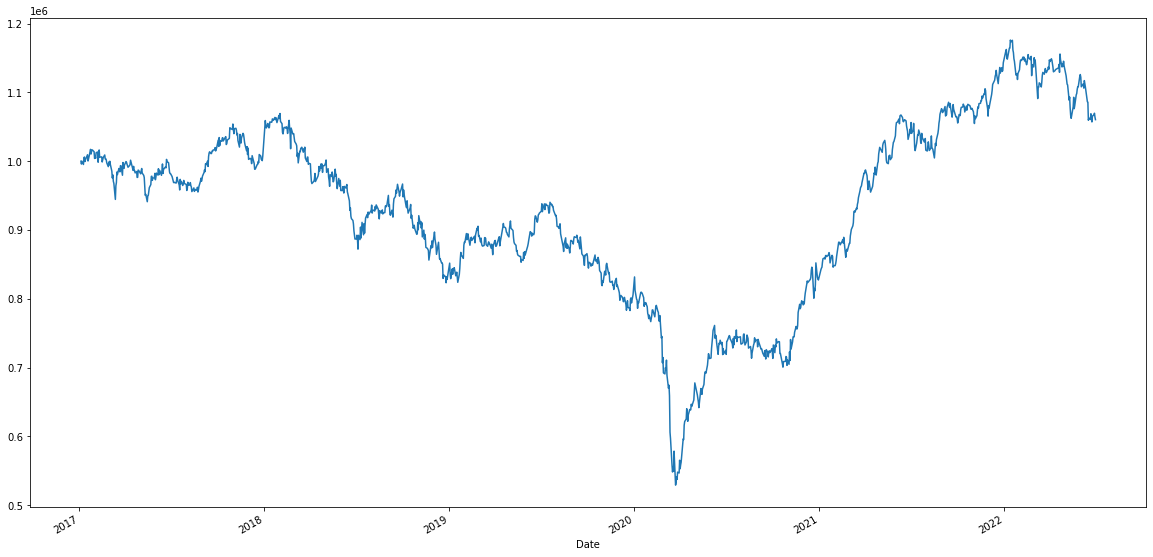

In [17]:
factor = 'SIZE'     # SIZE / VALUE / YIELD / MOMENTUM / VOLATILITY 
df_index_size = factor_index(factor , z_direction=1)        # z_direction = 1 / -1
index_size = df_index_size.groupby('Date')['CASH INVEST'].sum()
index_size.plot(figsize=(20,10))

<AxesSubplot:xlabel='Date'>

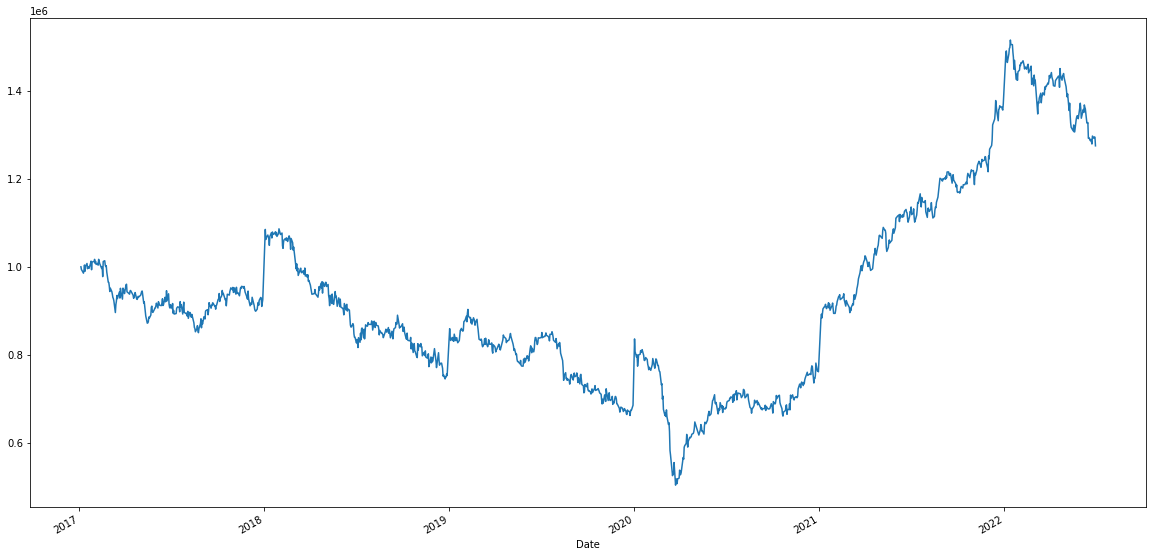

In [18]:
factor = 'VALUE'     # SIZE / VALUE / YIELD / MOMENTUM / VOLATILITY 
df_index_value = factor_index(factor , z_direction=1)
index_value = df_index_value.groupby('Date')['CASH INVEST'].sum()
index_value.plot(figsize=(20,10))

<AxesSubplot:xlabel='Date'>

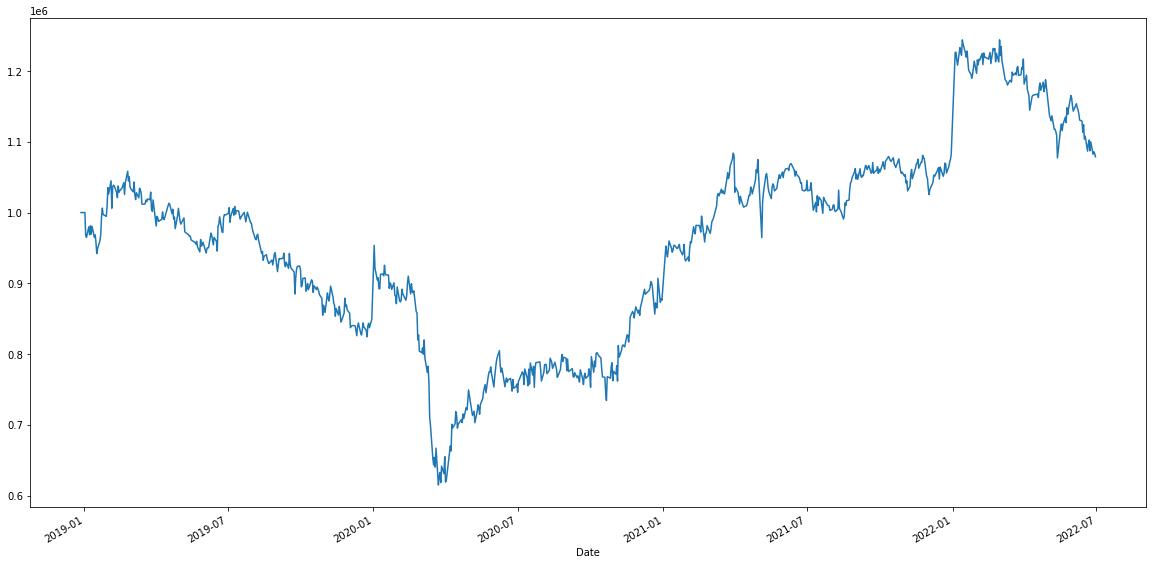

In [19]:
factor = 'YIELD'     # SIZE / VALUE / YIELD / MOMENTUM / VOLATILITY 
df_index_yield = factor_index(factor , z_direction=1)
index_yield = df_index_yield.groupby('Date')['CASH INVEST'].sum()
index_yield.plot(figsize=(20,10))

<AxesSubplot:xlabel='Date'>

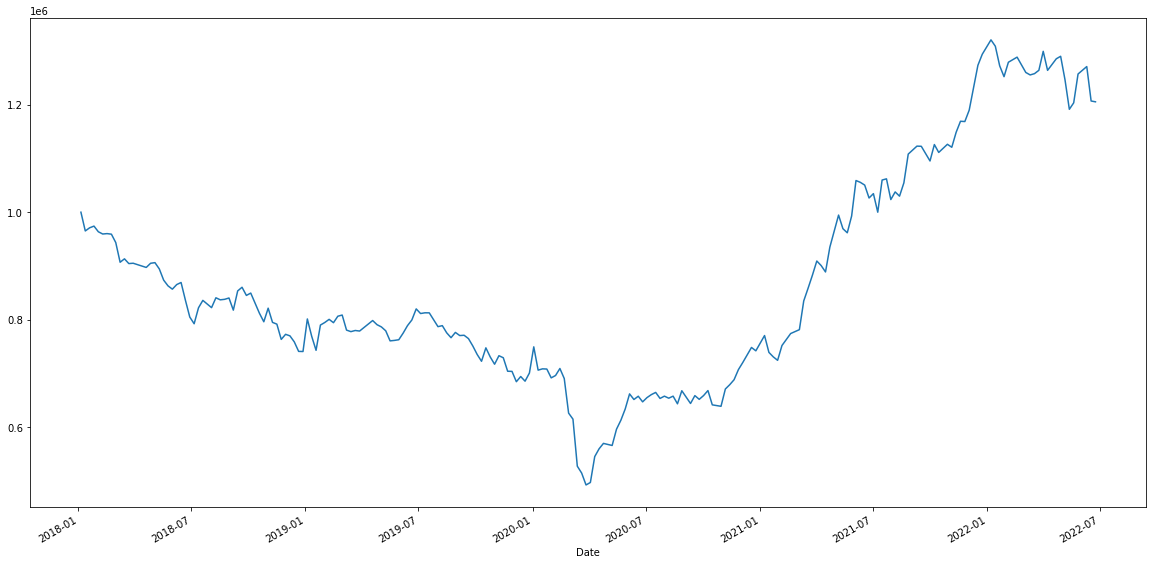

In [20]:
factor = 'MOMENTUM'     # SIZE / VALUE / YIELD / MOMENTUM / VOLATILITY 
df_index_momentum = factor_index(factor , z_direction=1)
index_momentum = df_index_momentum.groupby('Date')['CASH INVEST'].sum()
index_momentum.plot(figsize=(20,10))

<AxesSubplot:xlabel='Date'>

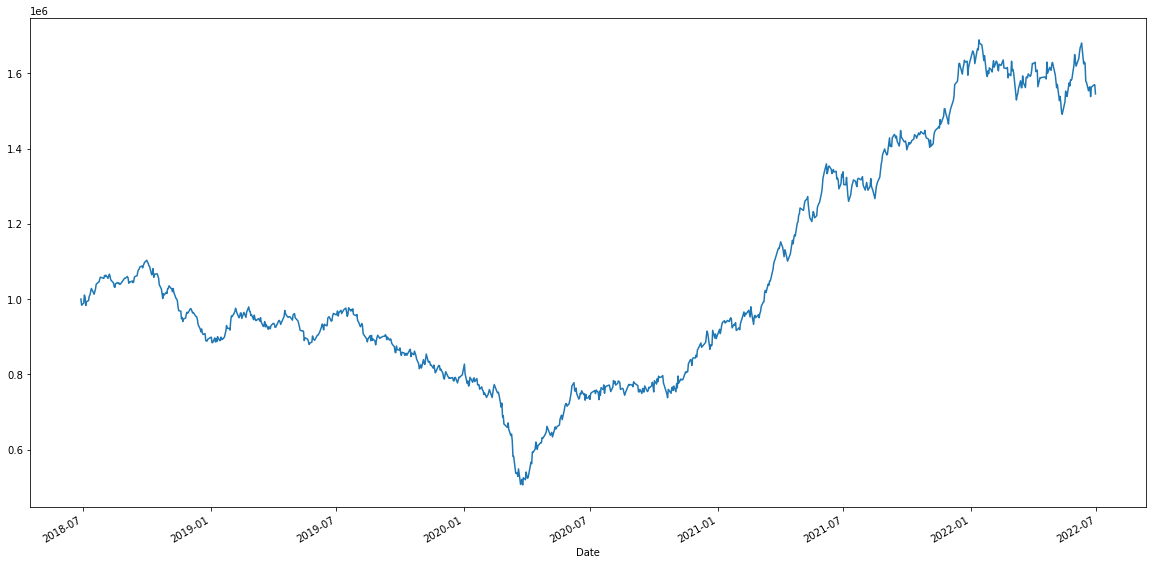

In [21]:
# HIGH VOLATILITY

factor = 'VOLATILITY'     # SIZE / VALUE / YIELD / MOMENTUM / VOLATILITY 
df_index_high_volatility = factor_index(factor , z_direction=1)
index_high_volatility = df_index_high_volatility.groupby('Date')['CASH INVEST'].sum()
index_high_volatility.plot(figsize=(20,10))

<AxesSubplot:xlabel='Date'>

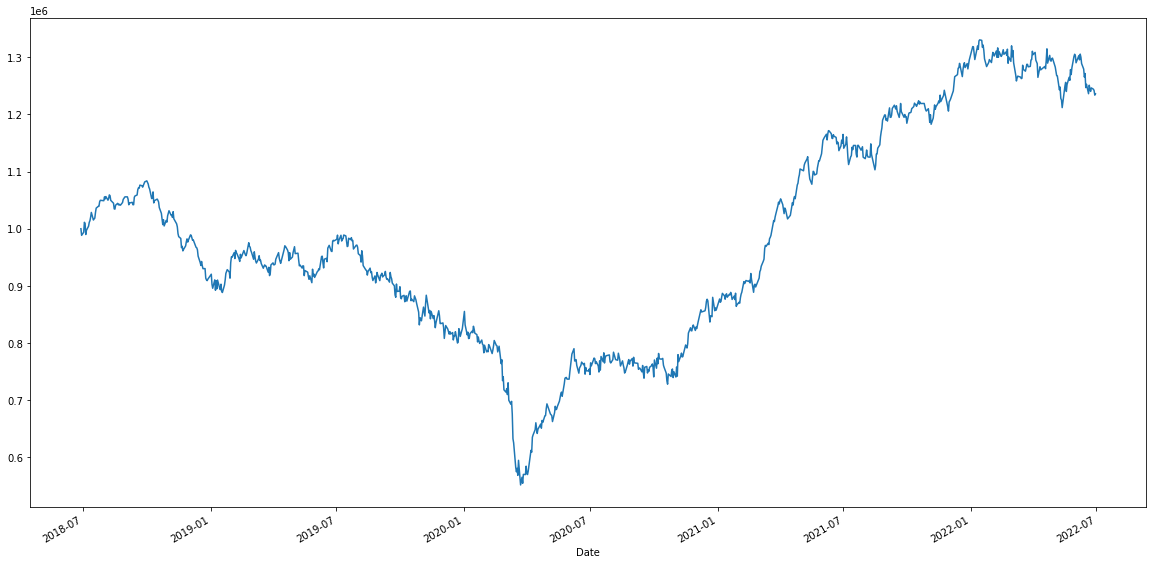

In [22]:
# LOW VOLATILITY (z = -1)

factor = 'VOLATILITY'     # SIZE / VALUE / YIELD / MOMENTUM / VOLATILITY 
df_index_low_volatility = factor_index(factor , z_direction=-1)
index_low_volatility = df_index_low_volatility.groupby('Date')['CASH INVEST'].sum()
index_low_volatility.plot(figsize=(20,10))